In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from scipy import spatial
import csv
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
def generateCountFeature(sentence_list, target, num_features=None):
    """
    Fit a CountVectorizer with specified number of max_features 
    on the sentence_list. Then transform the target to vector.
    Target is also a list of sentences.
    """
    ctv = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = num_features) 
    ctv.fit(sentence_list)
    target_feat = ctv.transform(target)
    target_feat = target_feat.toarray()
    #target_feat = target_feat.tolist()   
    return target_feat


def getCosSim(m1,m2):
    """
    Calculate cosine similarity for each pair of vectors in two matricies.
    For 0 vector, add 0.0001 to avoid calculation error. 
    """
    assert len(m1) == len(m2), "Matricies should have the same size."
    result = []
    for i in range(len(m1)):
        cos_sim = 1 - spatial.distance.cosine(m1[i], m2[i])
        result.append(cos_sim)
    return result

In [4]:
train_clean = pd.read_csv("./train_clean.csv")
train_clean = train_clean.fillna("")

In [5]:
train_clean.head()

,query,product_title,product_description,median_relevance,relevance_variance
0,bridal shower decoration,accent pillow heart design red black,red satin accent pillow embroider heart black ...,1,0.000
1,lead christmas light,set battery operate multi lead train christmas...,set battery operate train christmas light item...,4,0.000
2,projector,viewsonic pro dlp multimedia projector,,4,0.471
3,wine rack,concept housewares wr solid wood ceiling wall ...,like silent sturdy tree southern enterprise bi...,4,0.000
4,light bulb,wintergreen light christmas lead light bulb pack,wtgr feature nickel base average hour acrylic ...,2,0.471


### Correlation between input length and search relevance

I expect that the longer the inputs, the more relevant the results are. 

Text(0,0.5,'Median Relevance')

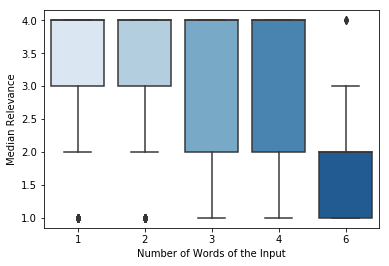

In [6]:
input_length = [len(i.split(" ")) for i in train_clean["query"]]
input_relevance = train_clean["median_relevance"]

ax = sns.boxplot(x=input_length, y=input_relevance, palette="Blues")
ax.set_xlabel('Number of Words of the Input')
ax.set_ylabel('Median Relevance')

However, from the boxplot, it seems that the actual trend is opposite. For input with length 1 and 2, although there are some completely uncorrelated search results, the overall relevance is the highest. On the other hand, for input with length 6, although there are some high correlated results, the overall relevance is actually the lowest. <br/>
So it seems that the length of input has some negative correlatoin with the relevance. It may be a useful feature.

In [7]:
file = open("input_length.csv", "w")
writer = csv.writer(file, delimiter = ",")
for i in input_length:
     writer.writerow([i])
file.close()

### Cosine similarity between columns

Also I expect the cosine similarity between input query and product title / product description may have some positive correlations with the search relevance. <br/>
For this part, I use count vectorizer to vectorize the texts.

In [8]:
sentence_list = list(train_clean['query']) + \
                list(train_clean['product_title']) + \
                list(train_clean['product_description'])

query_feat = generateCountFeature(sentence_list, list(train_clean['query']))
product_title_feat = generateCountFeature(sentence_list, list(train_clean['product_title'])) 
product_desc_feat = generateCountFeature(sentence_list, list(train_clean['product_description'])) 

query_title = getCosSim(query_feat, product_title_feat)
query_desc = getCosSim(query_feat, product_desc_feat)

In [9]:
input_relevance = train_clean["median_relevance"]

#### Input Query vs. Product Title

Text(0,0.5,'Cosine Similarity Between Input and Product Title')

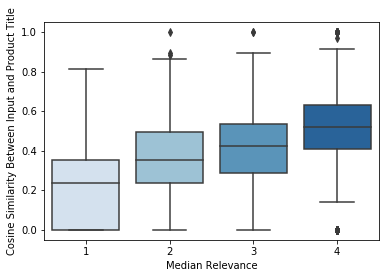

In [10]:
ax = sns.boxplot(x=input_relevance, y=np.array(query_title), palette="Blues")
ax.set_xlabel('Median Relevance')
ax.set_ylabel('Cosine Similarity Between Input and Product Title')

#### Input Query vs. Product Description

Text(0,0.5,'Cosine Similarity Between Input and Product Description')

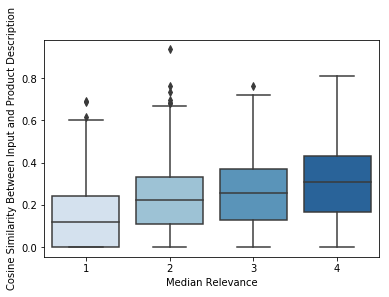

In [11]:
ax = sns.boxplot(x=input_relevance, y=np.array(query_desc), palette="Blues")
ax.set_xlabel('Median Relevance')
ax.set_ylabel('Cosine Similarity Between Input and Product Description')

From the plots, we can see that there is a postive relationship between cosine similarities and median relevance. So it might be a good feature as well. 

In [12]:
file = open("query_title.csv", "w")
writer = csv.writer(file, delimiter = ",")
for i in query_title:
     writer.writerow([i])
file.close()

In [13]:
file = open("query_desc.csv", "w")
writer = csv.writer(file, delimiter = ",")
for i in query_desc:
     writer.writerow([i])
file.close()

Generally speaking, product_title and product_description should always be similar, but it would be good to double check. 

#### Product Title vs. Product Description

In [14]:
title_desc = getCosSim(product_title_feat, product_desc_feat)

In [15]:
title_desc_woNA = [i for i in title_desc if not np.isnan(i)]
length = range(len(title_desc_woNA))

Text(0,0.5,'Cosine Similarity Between Product Title Product Description')

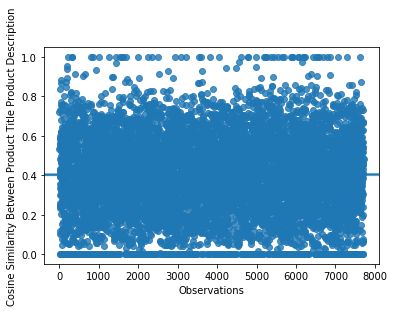

In [16]:
ax = sns.regplot(np.array(length),np.array(title_desc_woNA))
ax.set_xlabel('Observations')
ax.set_ylabel('Cosine Similarity Between Product Title Product Description')

It seems that product title and produt description are not always similar with each other eigher.